In [77]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession as spark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import time
import re

In [9]:
def runExperiment(inputUri, outputUri, appName, numCores):
    # fixed memory size
    sparkSession = SparkSession\
            .builder\
            .master('spark://192.168.2.25:7077') \
            .appName(appName)\
            .config('spark.dynamicAllocation.enabled', True)\
            .config('spark.dynamicAllocation.shuffleTracking.enabled',True)\
            .config('spark.shuffle.service.enabled', False)\
            .config('spark.dynamicAllocation.executorIdleTimeout','30s')\
            .config('spark.cores.max', numCores)\
            .config('spark.driver.port',9998)\
            .config('spark.blockManager.port',10005)\
            .config('spark.mongodb.input.uri', inputUri)\
            .config('spark.mongodb.output.uri', outputUri)\
            .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
            .getOrCreate()
    
    t = time.time()
    df = sparkSession.read.format('com.mongodb.spark.sql.DefaultSource').load()
    df = df.select('_id','year','loudness','tempo','artist_hotttnesss','beats_confidence','duration','artist_latitude','artist_longitude','key_confidence')
    df = df.withColumn('y_label', f.when(f.col('artist_hotttnesss') > 0.5, 1).otherwise(0))
    features = ['year', 'loudness', 'tempo', 'duration', 'key_confidence']
    label = 'y_label'

    assembler = VectorAssembler()\
            .setInputCols(features)\
            .setOutputCol('vectorized_features')
    df = assembler.transform(df)
    train, test = df.randomSplit([0.7, 0.3], seed = 2018)
    lr = LogisticRegression(featuresCol = 'vectorized_features', labelCol = 'y_label', maxIter=10)
    lrModel = lr.fit(train)
    d = time.time()
    duration = d - t

    sparkSession.stop()

    return duration

## Strong Scaling with 1.5 million data

In [80]:
numIterations = 10

## 2 cores

In [10]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '2 cores'
numCores = 2

resultsStrong2 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong2 = np.mean(resultsStrong2)
print(f'{resultsStrong2}, Avg: {avgStrong2}')

22/03/19 15:10:15 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/19 15:10:53 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[37.64454650878906, 21.657662391662598], Avg: 29.65110445022583


## 4 cores

In [11]:
input_uri_4c="mongodb://127.0.0.1/million_songs.songsOHalfM"
output_uri_4c="mongodb://127.0.0.1/million_songs.songsOHalfM"
appName = '4 cores'
numCores = 4

resultsStrong4 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong4 = np.mean(resultsStrong4)
print(f'{resultsStrong4}, Avg: {avgStrong4}')

22/03/19 15:11:16 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/19 15:11:37 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[21.180718421936035, 20.764941692352295], Avg: 20.972830057144165


## 8 cores

In [12]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '8 cores'
numCores = 8

resultsStrong8 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong8 = np.mean(resultsStrong8)
print(f'{resultsStrong8}, Avg: {avgStrong8}')

22/03/19 15:11:59 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/19 15:12:25 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[26.155293703079224, 26.0263991355896], Avg: 26.09084641933441


# 12 cores

In [13]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '12 cores'
numCores = 12

resultsStrong12 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong12 = np.mean(resultsStrong12)
print(f'{resultsStrong12}, Avg: {avgStrong12}')

22/03/19 15:12:52 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/19 15:13:21 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[28.013116598129272, 27.005247831344604], Avg: 27.50918221473694


## 16 cores

In [68]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '16 cores'
numCores = 16

resultsStrong16 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong16 = np.mean(resultsStrong16)
print(f'{resultsStrong16}, Avg: {avgStrong16}')

22/03/19 15:46:11 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/19 15:46:48 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[36.45588970184326, 36.4659218788147], Avg: 36.46090579032898


## Results

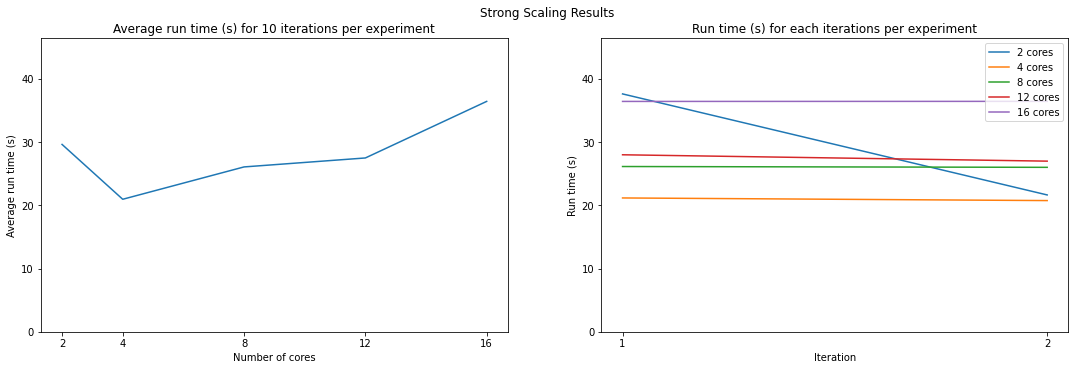

In [81]:
def printResults(results, labels, avgs, numIterations):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Strong Scaling Results')
    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)

    xAxis = [int(re.sub("[^0-9]", "", cores)) for cores in labels]
    yAxis = [avg for avg in avgs]

    ax1.plot(xAxis,yAxis)
    ax1.set_title('Average run time (s) for 10 iterations per experiment')
    ax1.set_xticks(xAxis)
    ax1.set_ylim(0,np.max(yAxis)+10)
    ax1.set_xlabel('Number of cores')
    ax1.set_ylabel('Average run time (s)')

    xAxis = range(1,numIterations+1)

    for i, result in enumerate(results):
        ax2.plot(xAxis, result, label=labels[i])
        
    ax2.set_title('Run time (s) for each iterations per experiment')
    ax2.set_xticks(xAxis)
    ax2.set_ylim(0,np.max(yAxis)+10)
    plt.legend(loc="upper right")
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Run time (s)')
    
    plt.show()
    
printResults([resultsStrong2, resultsStrong4, resultsStrong8, resultsStrong12, resultsStrong16],
             ['2 cores', '4 cores', '8 cores', '12 cores', '16 cores'],
             [avgStrong2, avgStrong4, avgStrong8, avgStrong12, avgStrong16], numIterations)

## Weak Scaling

In [82]:
numIterations = 10

## 250000 songs, 2 cores

In [72]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsQuarterM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsQuarterM'
appName = '250000 data for 2 cores'
numCores = 2

resultsWeak2 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak2 = np.mean(resultsWeak2)
print(f'{resultsWeak2}, Avg: {avgWeak2}')

22/03/19 16:00:06 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[18.497159481048584], Avg: 18.497159481048584


## 500000 songs, 4 cores

In [73]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsHalfM'
appName = '500000 data for 4 cores'
numCores = 4

resultsWeak4 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak4 = np.mean(resultsWeak4)
print(f'{resultsWeak4}, Avg: {avgWeak4}')

22/03/19 16:00:26 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[45.1025447845459], Avg: 45.1025447845459


## 100000 songs, 8 cores

In [74]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOneM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOneM'
appName = '1000000 data for 8 cores'
numCores = 8

resultsWeak8 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak8 = np.mean(resultsWeak8)
print(f'{resultsWeak8}, Avg: {avgWeak8}')

22/03/19 16:01:11 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[67.09422612190247], Avg: 67.09422612190247


## 500000 songs, 12 cores

In [75]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '1500000 data for 12 cores'
numCores = 12

resultsWeak12 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak12 = np.mean(resultsWeak12)
print(f'{resultsWeak12}, Avg: {avgWeak12}')

22/03/19 16:02:19 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[42.84381461143494], Avg: 42.84381461143494


## Results

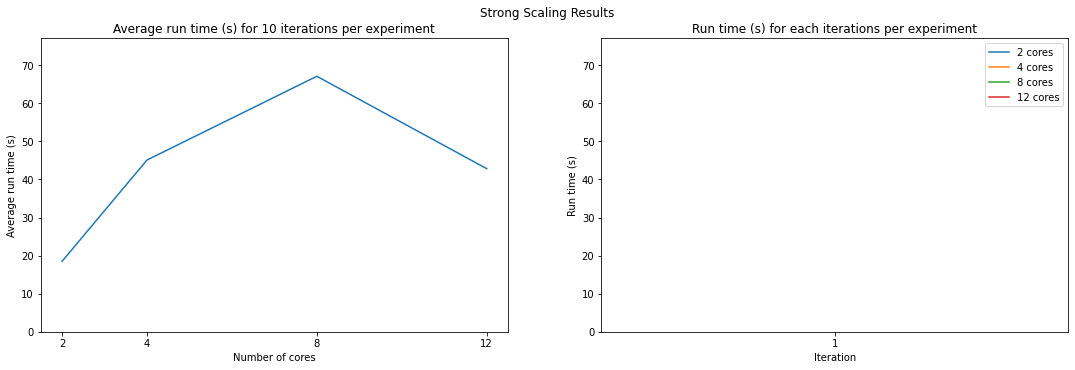

In [89]:
printResults([resultsWeak2, resultsWeak4, resultsWeak8, resultsWeak12],
             ['2 cores', '4 cores', '8 cores', '12 cores'],
             [avgWeak2, avgWeak4, avgWeak8, avgWeak12], numIterations)